In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot
from sklearn.calibration import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit


# Import mean squared error for evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error

from prophet import Prophet

import plotly.express as px
import plotly.graph_objects as go

from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



# Ensure that matplotlib plots display inline
%matplotlib inline
# Optional: Set plot styles for better aesthetics
sns.set(style='whitegrid')

In [5]:
# Replace 'sales_data.csv' with your actual file path or filename
df = pd.read_csv('./data/ventes_luxe_détaillées.csv', sep=';')

# Display the first few rows of the dataset
df.head()

# Assuming your data is in a DataFrame called df
df['ds'] = pd.to_datetime(df['Date'])
df['y'] = df['Montant_Ventes']


In [11]:

# Encode categorical variables if using regressors
df['category_encoded'] = df['Catégorie_Produit'].astype('category').cat.codes
df['channel_encoded'] = df['Canal_Vente'].astype('category').cat.codes

# Define holidays/events
holidays = pd.DataFrame({
    'holiday': 'special_event',
    'ds': df[df['Événement_Spécial'] == 1]['ds'],
    'lower_window': 0,
    'upper_window': 1
})

# Initialize the model
model = Prophet(
    growth='linear',
    n_changepoints=30,
    changepoint_range=0.9,
    changepoint_prior_scale=0.1,
    yearly_seasonality=10,
    weekly_seasonality=5,
    seasonality_mode='multiplicative',
    holidays=holidays,
    holidays_prior_scale=20,
    interval_width=0.95
)

# Add regressors if needed
model.add_regressor('category_encoded')
model.add_regressor('channel_encoded')

# Fit the model
model.fit(df)

# # Make future dataframe
future = model.make_future_dataframe(periods=30)  # Forecasting 30 days ahead




11:14:01 - cmdstanpy - INFO - Chain [1] start processing
11:14:08 - cmdstanpy - INFO - Chain [1] done processing


In [15]:

le_category = LabelEncoder()
df['category_encoded'] = le_category.fit_transform(df['Catégorie_Produit'])

le_channel = LabelEncoder()
df['channel_encoded'] = le_channel.fit_transform(df['Canal_Vente'])

# # # Add regressors to future dataframe
future['category_encoded'] = df['category_encoded']
future['channel_encoded'] = df['channel_encoded']
# Predict
forecast = model.predict(future)

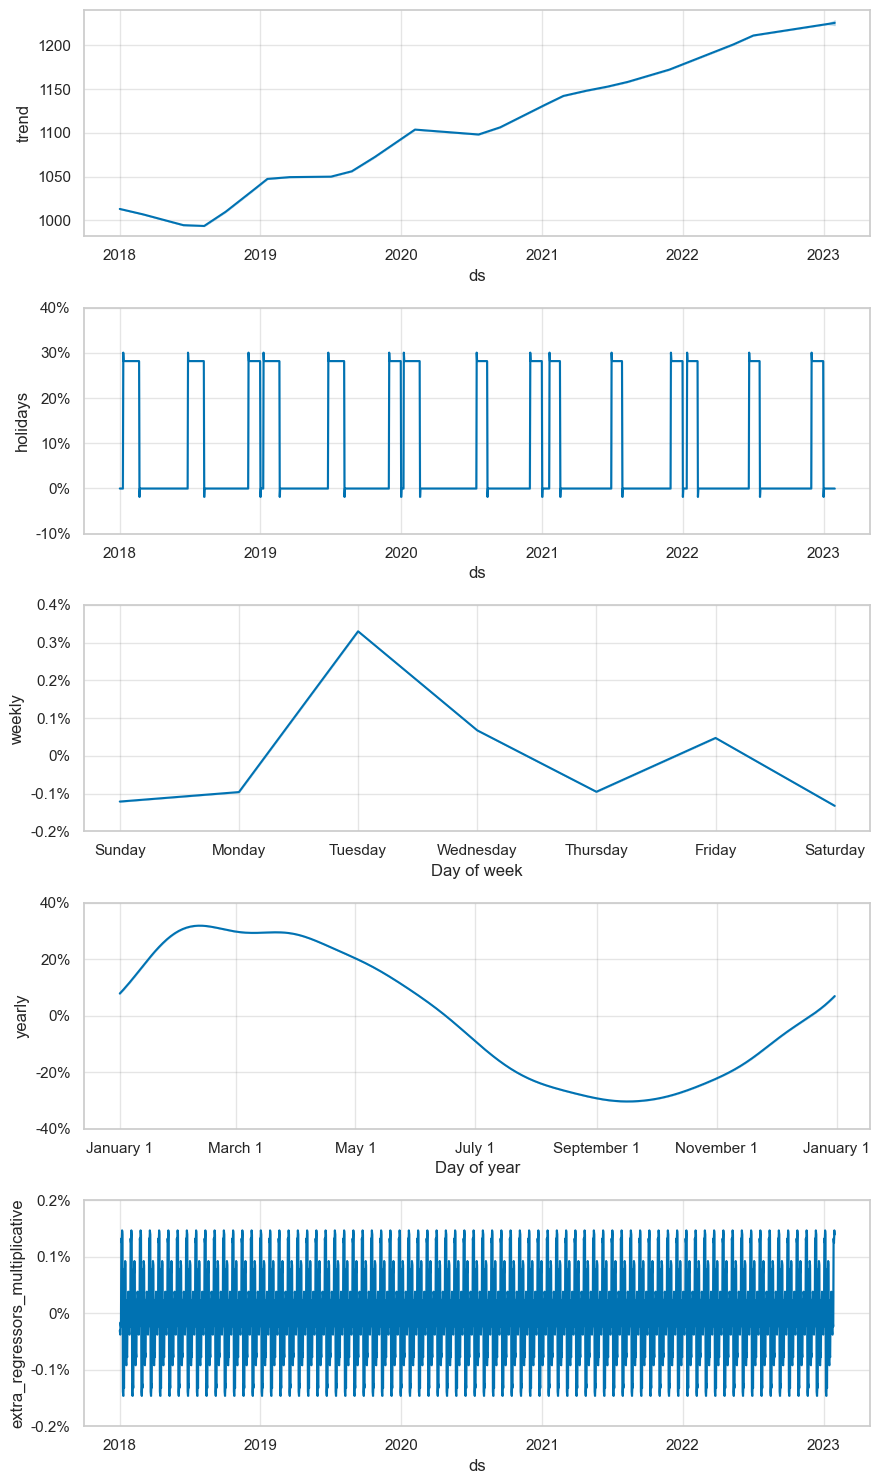

In [17]:
model.plot_components(forecast)
plt.show()

In [19]:
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
}

import itertools
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

for params in all_params:
    model = Prophet(**params).fit(df)
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


11:18:52 - cmdstanpy - INFO - Chain [1] start processing
11:18:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]11:18:56 - cmdstanpy - INFO - Chain [1] start processing
11:18:57 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:02<00:09,  2.30s/it]11:18:58 - cmdstanpy - INFO - Chain [1] start processing
11:18:59 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:04<00:07,  2.52s/it]11:19:01 - cmdstanpy - INFO - Chain [1] start processing
11:19:03 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]11:19:04 - cmdstanpy - INFO - Chain [1] start processing
11:19:06 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:11<00:03,  3.03s/it]11:19:08 - cmdstanpy - INFO - Chain [1] start processing
11:19:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:15<00:00,  3.11s/it]
11:19:13 - cmdstanpy - INFO - Chain [1] start processing
11

   changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.01                      0.1  197.863999
1                     0.01                      1.0  197.660794
2                     0.01                     10.0  197.764690
3                     0.10                      0.1  228.527627
4                     0.10                      1.0  225.750815
5                     0.10                     10.0  226.497126
6                     0.50                      0.1  273.288003
7                     0.50                      1.0  299.664857
8                     0.50                     10.0  314.516612


# Interpretation
## changepoint_prior_scale Impact:

#### Smaller Values (0.01):

- Lead to a smoother trend with fewer abrupt changes.
The model is less flexible in fitting to noise, reducing the risk of overfitting.
Results in better performance (lower RMSE).

#### Larger Values (0.10 and 0.50):

- Allow the model to fit more closely to short-term fluctuations.
Increase the risk of overfitting to noise in the data.
Result in worse performance (higher RMSE).

#### Conclusion: 
Your data benefits from a less flexible trend component, **suggesting that the underlying trend is relatively stable without abrupt changes.**

## seasonality_prior_scale Impact:

Changes in seasonality_prior_scale have a minor effect on RMSE.
This indicates that the model's performance is less sensitive to the flexibility of the seasonal components.

#### Possible Reasons:
Seasonal patterns in your data are well-captured even with default settings.
The seasonal effects may not be highly complex, so increasing flexibility doesn't significantly improve the fit.

#### Conclusion: 
Adjusting seasonality_prior_scale within the tested range doesn't substantially affect model performance.

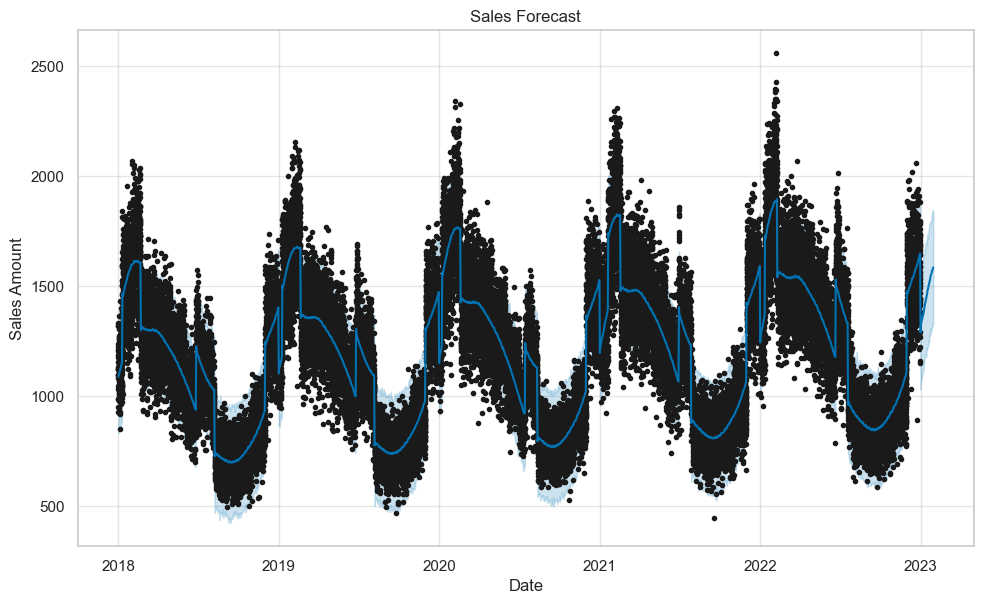

In [21]:
fig1 = model.plot(forecast)
ax = fig1.gca()
ax.set_title('Sales Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
plt.show()